[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ourownstory/neural_prophet/blob/master/tutorials/feature-use/benchmarking.ipynb)

# Running benchmarking experiments
Note: The Benchmarking Framework does currently not properly support auto-regression or lagged covariates with multiple step ahead forecasts.

In [1]:
if 'google.colab' in str(get_ipython()):
    !pip install git+https://github.com/ourownstory/neural_prophet.git # may take a while
    #!pip install neuralprophet # much faster, but may not have the latest upgrades/bugfixes
    
import pandas as pd
from neuralprophet import NeuralProphet, set_log_level
from neuralprophet.benchmark import Dataset, NeuralProphetModel, ProphetModel, SimpleExperiment, CrossValidationExperiment
from neuralprophet.benchmark import SimpleBenchmark, CrossValidationBenchmark
set_log_level("ERROR")

WARNING - (NP.benchmark.<module>) - Benchmarking Framework is not covered by tests. Please report any bugs you find.


## Load data

In [2]:
data_location = "https://raw.githubusercontent.com/ourownstory/neuralprophet-data/main/datasets/"

air_passengers_df = pd.read_csv(data_location + 'air_passengers.csv')
peyton_manning_df = pd.read_csv(data_location + 'wp_log_peyton_manning.csv')
# retail_sales_df = pd.read_csv(data_location + 'retail_sales.csv')
# yosemite_temps_df = pd.read_csv(data_location +  'yosemite_temps.csv')
# ercot_load_df = pd.read_csv(data_location +  'ERCOT_load_2004_2021Sept.csv')[['ds', 'y']]

## 0. Configure Datasets and Model Parameters
First, we define the datasets that we would like to benchmerk on.
Next, we define the models that we want to evaluate and set their hyperparameters.

In [3]:
dataset_list = [
    Dataset(df = air_passengers_df, name = "air_passengers", freq = "MS"),
    # Dataset(df = peyton_manning_df, name = "peyton_manning", freq = "D"),
    # Dataset(df = retail_sales_df, name = "retail_sales", freq = "D"),
    # Dataset(df = yosemite_temps_df, name = "yosemite_temps", freq = "5min"),
    # Dataset(df = ercot_load_df, name = "ercot_load", freq = "H"),
]
model_classes_and_params = [
    (NeuralProphetModel, {"seasonality_mode": "multiplicative", "learning_rate": 0.1}),
    (ProphetModel, {"seasonality_mode": "multiplicative"})
]

Note: As all the classes used in the Benchmark framework are dataclasses, 
they have a print function, allowing us to peek into them if we like:

In [4]:
model_classes_and_params

[(neuralprophet.benchmark.NeuralProphetModel,
  {'seasonality_mode': 'multiplicative', 'learning_rate': 0.1}),
 (neuralprophet.benchmark.ProphetModel,
  {'seasonality_mode': 'multiplicative'})]

## 1. SimpleBenchmark
Setting up a series of Train Test Experiments is quick:

In [ ]:
benchmark = SimpleBenchmark(
    model_classes_and_params=model_classes_and_params, # iterate over this list of tuples
    datasets=dataset_list, # iterate over this list
    metrics=["MAE", "MSE", "MASE", "RMSE"],
    test_percentage=25,
)
results_train, results_test = benchmark.run()

In [6]:
results_test

,data,model,params,MAE,MSE,MASE,RMSE
0,air_passengers,NeuralProphet,"{'seasonality_mode': 'multiplicative', 'learni...",24.480665,825.144314,0.563700,28.725325
1,air_passengers,Prophet,{'seasonality_mode': 'multiplicative'},29.818648,1142.139138,0.686614,33.795549


## 2. CrossValidationBenchmark
Setting up a series of crossvalidated experiments is just as simple:

In [ ]:
benchmark_cv = CrossValidationBenchmark(
    model_classes_and_params=model_classes_and_params, # iterate over this list of tuples
    datasets=dataset_list, # iterate over this list
    metrics=["MASE", "RMSE"],
    test_percentage=10,
    num_folds=3,
    fold_overlap_pct=0,
)
results_summary, results_train, results_test = benchmark_cv.run()

We now also get a summary DataFrame showing the metrics' mean and standard deviation over all folds.

In [8]:
results_summary

,data,model,params,MASE,RMSE,MASE_std,RMSE_std,split
0,air_passengers,NeuralProphet,"{'seasonality_mode': 'multiplicative', 'learni...",0.280001,7.689837,0.010209,0.699286,train
1,air_passengers,Prophet,{'seasonality_mode': 'multiplicative'},0.310869,8.616463,0.021078,1.266764,train
0,air_passengers,NeuralProphet,"{'seasonality_mode': 'multiplicative', 'learni...",0.487840,22.606768,0.146416,6.029284,test
1,air_passengers,Prophet,{'seasonality_mode': 'multiplicative'},0.479454,22.778341,0.109195,4.224042,test


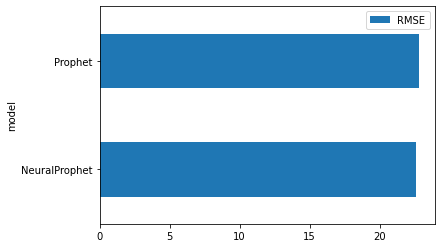

In [11]:
air_passengers = results_summary[results_summary['data'] == 'air_passengers']
air_passengers = air_passengers[air_passengers['split'] == 'test']
plt = air_passengers.plot(x='model', y='RMSE', kind='barh')

The metrics for each fold are also recoreded individually:

In [10]:
results_test

,data,model,params,MASE,RMSE
0,air_passengers,NeuralProphet,"{'seasonality_mode': 'multiplicative', 'learni...","[0.501806261640113, 0.3019438296724765, 0.6597...","[21.11287120361771, 16.083599711146324, 30.623..."
1,air_passengers,Prophet,{'seasonality_mode': 'multiplicative'},"[0.5885898654326461, 0.3302688815416577, 0.519...","[24.617703272976527, 16.936631879241148, 26.78..."
